<img style="float: right;" src="./img/es2_logo_tiny.jpg"></img>

<h1 align="center">Time-series retrieval - Climate Sciences</h1>
<h3 align="center">Example of creating a climate graph of Brussels</h3>
<hr>

<a href="./Point-extraction_example_marine_sciences.ipynb"><< 02-Single-point extraction - Marine Sciences </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./Monthly-averages_climate_sciences.ipynb">04-Glocal monthly anomalies - Climate Sciences >></a>

### Background

The fast and efficient extraction of time-series information from a three-dimensional data cube is challenging. If the data is provided with the help of a web service, every data layer from the cube has to be accessed in order to retrieve the required information. Traditional data access systems would even require the download of multiple 2D data sets.
Access of multiple two-dimensional layers is costly in terms of efficiency. Most WebAPI's are very efficient in the retrieval of geographical subsets but are only suboptimal for time-series retrieval.

<br>

<img style="float: center; width: 70%; height:70%" src="./img/single_point_extraction_small.png"></img>


### Addressed community

* of interest across all Earth Science domains

### Benefits

Web Coverage Service 2.0 with its processing extension Web Coverage Processing Service (WCPS) offers an efficient retrieval of time-series data without data download.

<hr>

## EXAMPLE: Creating a climate graph of Brussels

### Description

A climate graph is commonly used to describe the average weather of one specific location. A climate graph contains: 
* the <b>average, minimum and maximum temperature</b> of every month and 
* the <b>average precipitation</b> of every month.


<h3>Data required</h3>
<div class="alert alert-info">
<ul type="square">
<li><a href="http://www.ecmwf.int/en/research/climate-reanalysis/era-interim">ERA-Interim reanalysis</a> -  2m air temperature and total precipitation from 1 January 1979 to 31 December 2014</li>
<li><b>Format:</b> GRIB</li>
<li><b>Spatial resolution:</b> Lat/Lon grid, 0.5 x 0.5 degrees, 720 x 361 gridpoints</li>
<li><b>Temporal resolution:</b> 6-hourly</li>
<li><b>Data volume:</b> 27 GB per parameter</li>
</ul>
</div>

<h3> Workflow </h3>
<div class="alert alert-success">
<ul type="square">
<li>(1) Retrieve monthly mean, min and max 2m air temperature from Jan 1979 to Dec 2014</li>
<li>(2) Retrieve monthly sums of total precipitation from Jan 1979 to Dec 2014</li>
<li>(3) Calculate averages for every month for every parameter</li>
<li>(4) Plot the climate graph</li>
</ul>
</div>


### Alternative 

The alternative to the retrieval of the time-series via a Web Coverage Service would be to access the data via the MARS WebAPI. This however would require the download, storage and extensive processing of two parameters, both of a volume of several GBs.

<hr>

#### Load required libraries

In [1]:
%matplotlib inline
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import collections

<b>Define the WCPS query</b>

With one WCPS request, 
* the data can be converted into a different unit, e.g. from Kelvin to degree Celsius, and 
* a mathematical condenser, e.g. average, minimum or maximum, can be applied to the data values retrieved

In [70]:
# WCPS query format for 2m air temperature (conversion of Kelvin to degree Celsius)
url_fmt_temp = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
          '&request=ProcessCoverages' \
          '&query=for c in (%s) return encode(%s(c[Lat(%d:%d), Long(%d:%d),ansi("%s":"%s")] - 273.15), "csv")'

# WCPS query format for total precipitation (conversion from m of water to mm of water)
url_fmt_precip = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
          '&request=ProcessCoverages' \
          '&query=for c in (%s) return encode(%s(c[Lat(%d:%d), Long(%d:%d),ansi("%s":"%s")] * 1000), "csv")'

#### Helper functions

In [71]:
# A list for every first day in the month from Jan 1979 to Dec 2014
startDateList = (range(432))
x =datetime(1979,1,1,0)
for i in range(0,len(startDateList)):
    startDateList[i]=x
    x=(x.replace(day=1)+timedelta(days=31)).replace(day=1)

# A list with every last day of the month from Jan 1979 to Dec 2014
endDateList = (range(432))
for i in range(0, len(endDateList)):
    y = startDateList[i].replace(hour=18) + relativedelta(day=31)
    endDateList[i]=y

startDateListISO=(range(432))
for i in range(0,len(startDateListISO)):
    startDateListISO[i]=startDateList[i].date().isoformat()

#### Function to retrieve data from the Web Coverage Service

In [75]:
# Function that retrieves for every month all data values from the WCS server and appends the outputs to a python list
def retrieveFromWCS(param, operation, latMin, latMax, lonMin, lonMax):
    if param=="precipitation":
        startDateList[0]=startDateList[0] + timedelta(days=1)
        query = url_fmt_precip
    else:
        query = url_fmt_temp
    monthlyTS = []
    for i,j in zip(startDateList,endDateList):
        url = query % (param, operation, latMin,latMax,lonMin,lonMax,i.isoformat(),j.isoformat())
        r= requests.get(url,
                proxies={'http':None}
                )

        r.raise_for_status()
        y= [float(a) for a in r.text[1:-1].split(",")]
        monthlyTS.append(y[0])
    return monthlyTS

#### (1) Retrieve average, minimum and maximum surface temperature for Brussels for every month

In [42]:
latMin = 50.52
latMax = 50.52
lonMin = -4.22
lonMax = -4.22
monthlyTS_avg = retrieveFromWCS("temp2m", "avg", latMin, latMax, lonMin, lonMax)
monthlyTS_max = retrieveFromWCS("temp2m", "max", latMin, latMax, lonMin, lonMax)
monthlyTS_min = retrieveFromWCS("temp2m", "min", latMin, latMax, lonMin, lonMax)

#### (2) Retrieve monthly sums of total precipitation for Brussels for every month

In [76]:
latMin = 50.52
latMax = 50.52
lonMin = -4.22
lonMax = -4.22
monthlyTS_sum = retrieveFromWCS("precipitation", "add", latMin, latMax, lonMin, lonMax)

#### (3) Calculate averages for every month for every parameter

In [90]:
def calculateMonthlyAvgTS (inputArray):
    tmp = np.empty((12))
    for i in range(0,12):
        month = inputArray[i::12]
        tmp[i] = np.mean(month, axis=0)
    return tmp

monthsAvg = calculateMonthlyAvgTS(monthlyTS_avg)
monthsMax = calculateMonthlyAvgTS(monthlyTS_max)
monthsMin = calculateMonthlyAvgTS(monthlyTS_min)
monthsAvg_precip = calculateMonthlyAvgTS(monthlyTS_sum)

#### (4) Plot the climate graph for Brussels

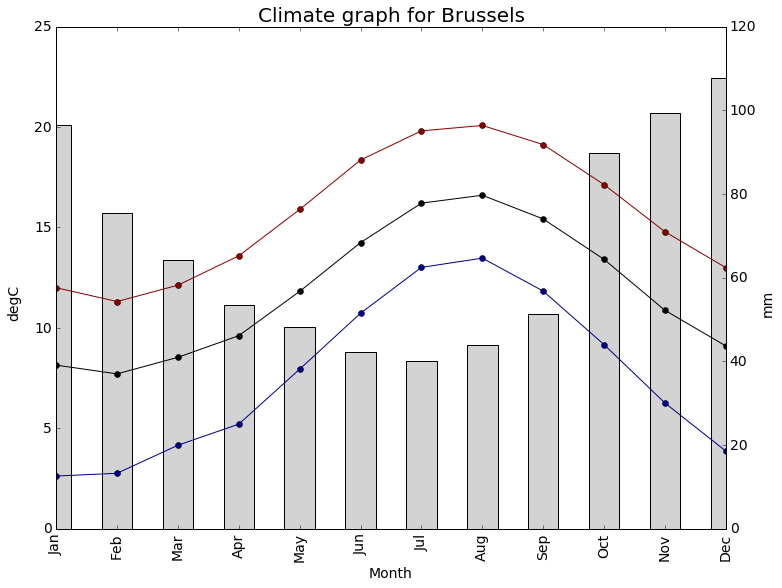

In [285]:
from ggplot import *
import pandas
import matplotlib.pyplot as plt

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
columns = ["temp_avg", "temp_max", "temp_min"]

df = pandas.DataFrame(months, columns=['Month'])
df['temp_avg'] = pandas.Series(monthsAvg, index=df.index)
df['temp_max'] = pandas.Series(monthsMax, index=df.index)
df['temp_min'] = pandas.Series(monthsMin, index=df.index)
df['precip_avg'] =pandas.Series(monthsAvg_precip, index=df.index)

ax1 = df[['Month','precip_avg']].plot(x='Month',kind='bar',color='#D3D3D3', legend=False, \
                                     figsize=(12,9), fontsize=12)

ax2 = ax1.twinx()
df[['Month', 'temp_avg']].plot(x='Month',linestyle='-',marker='o', ax=ax2,color='black', legend=False)
df[['Month', 'temp_max']].plot(x='Month', linestyle='-',marker='o',ax=ax2,color='darkred',legend=False)
df[['Month', 'temp_min']].plot(x='Month', linestyle='-',marker='o',ax=ax2,color='darkblue', legend=False)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_title("Climate graph for Brussels", fontsize=20)
ax1.set_xlabel("Month", fontsize=14)
ax2.set_ylabel("mm", labelpad=35, y=0.45, fontsize=14)
ax1.set_ylabel("degC", labelpad=35, y=0.45,fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

plt.show()

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>